# Wind Turbine Power Generation Forecasting

Train dataset contains hourly meteorological data along with power output measurements collected between January 2013 and December 2016. The data includes variables such as temperature, relative humidity, wind speed at various altitudes, and power generated at different locations.

1. Import dependencies.

In [1]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler

from lib.ml.layer.layer_def import Dense, Input
from lib.ml.util.loss_function import MEAN_SQUARED_ERROR
from lib.ml.model.seq_model import SeqNet, ValidationData
from lib.ml.optimizer.genetic_optimizer import GeneticOptimizer
from lib.ml.util.progress_tracker import NotebookProgressTracker
from lib.ml.util.data_tweaks import split_with_ration
from lib.ml.util.activation_function import RELU_ACTIVATION
from src.data.wind_turbine.wind_turbine_dataset import (
    download_wind_turbine_dataset,
    process_wind_turbine_dataset,
    extract_x_y_from_turbine_dataset,
)
from src.definitions import EXTERNAL_DATA_FOLDER
from src.definitions import TEST_TRAIN_RATIO
from src.visualization.plot import plot_loss_and_val_loss, plot_diff

2. Download and process `sudhanvahg/wind-turbine-power-generation-forecasting` dataset.

In [2]:
archive = download_wind_turbine_dataset(EXTERNAL_DATA_FOLDER)
train, test = process_wind_turbine_dataset(archive, test_train_ratio=TEST_TRAIN_RATIO)

train.head(5)

,Location,Temp_2m,RelHum_2m,DP_2m,WS_10m,WS_100m,WD_10m,WD_100m,WG_10m,Power
10817,3,55.6796,43.664205,33.972595,0.665389,0.717799,216.051683,261.057315,5.736515,0.039396
24515,1,61.4796,60.664205,47.772595,1.655389,1.937799,289.051683,290.057315,4.336515,0.336896
8616,4,-5.4204,61.664205,-15.327405,4.415389,6.797799,310.051683,313.057315,7.436515,0.209496
30909,1,64.0796,77.664205,56.772595,2.325389,4.857799,346.051683,351.057315,4.836515,0.244296
3404,2,51.1796,62.664205,38.672595,3.005389,5.617799,38.051683,39.057315,6.636515,0.276196


3. Define neural network.

In [3]:
model = SeqNet(
    layers=[
        Input(9),
        Dense(32, activation_fun=RELU_ACTIVATION),
        Dense(1),
    ]
)

opt = GeneticOptimizer(
    population_size=200, mutation_rate=0.5, mutation_decay=0.005
)

compiled_model = model.compile(
    optimizer=opt,
    loss=MEAN_SQUARED_ERROR,
    progress_tracker=NotebookProgressTracker(),
)

4. Train neural network.

In [4]:
train, validation = split_with_ration(train, 0.9)

train_x, train_y = extract_x_y_from_turbine_dataset(train)
validation_x, validation_y = extract_x_y_from_turbine_dataset(validation)

scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
validation_x_scaled = scaler.transform(validation_x)

validation_data = ValidationData(validation_x_scaled.T, validation_y)

trained_model = compiled_model.fit(train_x_scaled.T, train_y, 300, validation_data=validation_data)

print("Train accuracy = " + str(trained_model.train_loss()))

Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Train accuracy = 0.1480634104670671


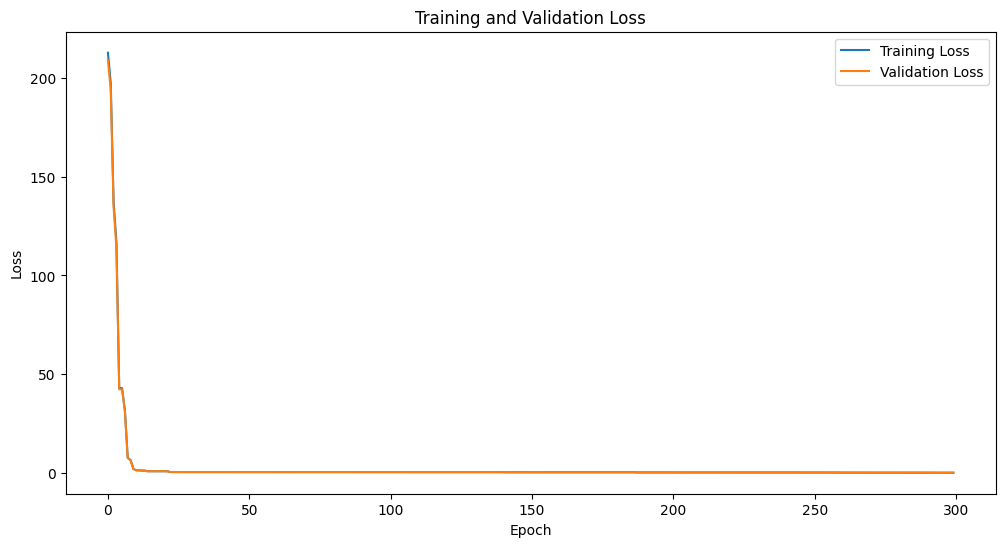

In [5]:
plot_loss_and_val_loss(trained_model)

5. Test neural network.

In [6]:
test_x, test_y = extract_x_y_from_turbine_dataset(test)

test_x_scaled = scaler.transform(test_x)

y_predicted = trained_model.predict(test_x_scaled.T)

print("Test accuracy = " + str(MEAN_SQUARED_ERROR.apply(test_y, y_predicted)))

Test accuracy = 0.14937009204124668


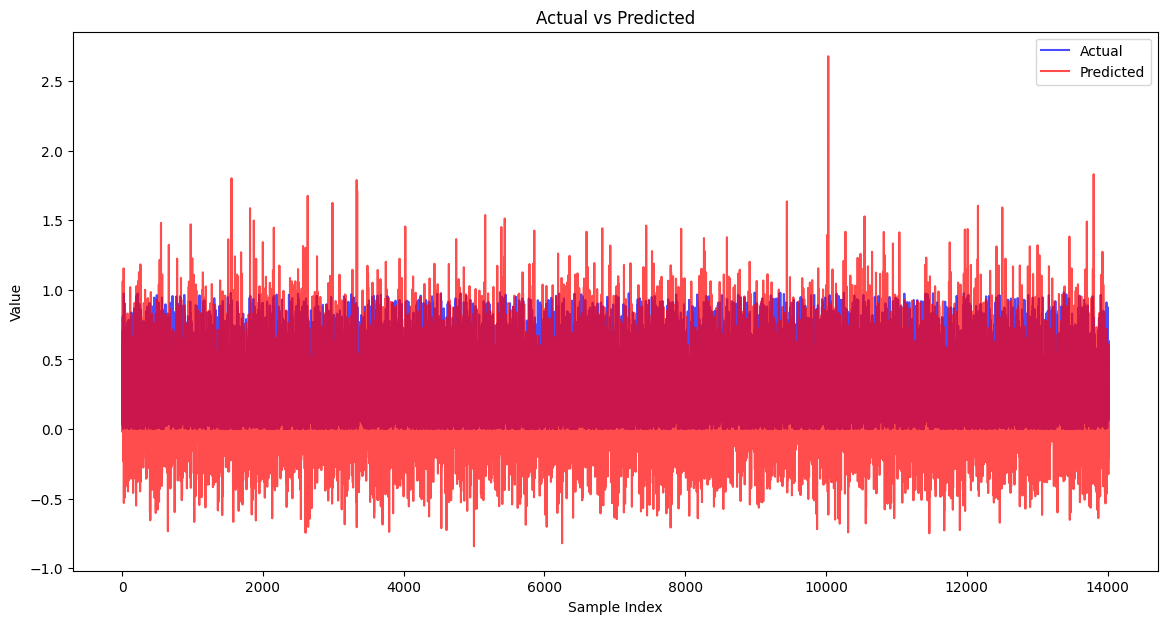

In [7]:
plot_diff(test_y.flatten(), y_predicted.flatten())

In [9]:
delta = test_y - y_predicted

report = pd.DataFrame(
    {
        "Power RO": test_y.flatten(),
        "Power PO": y_predicted.flatten(),
        "DELTA": delta.flatten(),
        "DELTA^2": np.square(delta.flatten()),
    }
)

report_head = report.head(12)

display(report_head)

print("Delta total = " + str(report_head["DELTA"].sum()))
print("Delta^2 total = " + str(report_head["DELTA^2"].sum()))

,Power RO,Power PO,DELTA,DELTA^2
0,0.699596,0.229708,0.469888,0.220795
1,0.031496,0.159437,-0.127941,0.016369
2,0.081296,0.359685,-0.278389,0.077501
3,0.241396,-0.021633,0.263029,0.069184
4,0.617996,0.229287,0.388709,0.151095
5,0.030396,0.197609,-0.167213,0.027960
6,0.185796,0.324980,-0.139184,0.019372
7,0.808396,1.062427,-0.254031,0.064532
8,0.580496,0.312398,0.268098,0.071876
9,0.290796,0.634158,-0.343362,0.117897


Delta total = 0.49723110952273636
Delta^2 total = 1.0001475878195145
